# Introduction to Transfer Learning
This notebook is part of the [SachsLab Workshop for Intracranial Neurophysiology and Deep Learning](https://github.com/SachsLab/IntracranialNeurophysDL).

### Lesson Reference
To supplement the presented material, consult the tutorial here: https://www.tensorflow.org/beta/tutorials/images/transfer_learning
* Freeze most layers, update only certain layer(s), then unfreeze all and update

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/04_02_CNN_transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/04_02_CNN_transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

### Normalize Environments
Run the first two cells to normalize Local / Colab environments, then proceed below for the lesson.

In [1]:
from pathlib import Path
import os
try:
    # See if we are running on google.colab
    import google.colab
    from google.colab import files
    os.chdir('..')
    if not (Path.home() / '.kaggle').is_dir():
        # Configure kaggle
        files.upload()  # Find the kaggle.json file in your ~/.kaggle directory.
        !pip install -q kaggle
        !mkdir -p ~/.kaggle
        !mv kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
    if Path.cwd().stem != 'IntracranialNeurophysDL':
        if not (Path.cwd() / 'IntracranialNeurophysDL').is_dir():
            # Download the workshop repo and change to its directory
            !git clone --recursive https://github.com/SachsLab/IntracranialNeurophysDL.git
        os.chdir('IntracranialNeurophysDL')
    IN_COLAB = True
    # Setup tensorflow 2.0
    !pip install -q tensorflow-gpu==2.0.0-beta0
except ModuleNotFoundError:
    IN_COLAB = False
    import sys
    if Path.cwd().stem == 'notebooks':
        os.chdir(Path.cwd().parent)
    # Make sure the kaggle executable is on the PATH
    os.environ['PATH'] = os.environ['PATH'] + ';' + str(Path(sys.executable).parent / 'Scripts')

# Try to clear any logs from previous runs
if (Path.cwd() / 'logs').is_dir():
    import shutil
    try:
        shutil.rmtree(str(Path.cwd() / 'logs'))
    except PermissionError:
        print("Unable to remove logs directory.")

In [2]:
# Additional imports
import tensorflow as tf
import datetime
import numpy as np
import matplotlib.pyplot as plt
from indl import turbo_cmap, reset_keras

# %load_ext tensorboard
plt.rcParams.update({'font.size': 22})
%load_ext autoreload
%autoreload 2

In [3]:
# Download and unzip data
datadir = Path.cwd() / 'data' / 'kjm_ecog'
if not (datadir / 'converted').is_dir():
    !kaggle datasets download --unzip --path {str(datadir / 'converted' / 'faces_basic')} cboulay/kjm-ecog-faces-basic
    print("Finished downloading and extracting data.")
else:
    print("Data directory found. Skipping download.")

Data directory found. Skipping download.


## Strategy

The model comprises a block for temporal filters, a block for a spatial filter, a block for further convolutional layers, and a block for the classifier. The spatial filter is going to be unique to each recording, but the other blocks could be shared across recordings.

If we start with a well-performing model for one recording then whenever we switch to a new recording the different sensor locations are going to be a poor fit and create large errors. We don't want those errors to propagate through and update weights in the entire model. For each new recording, we freeze the layers that are shared so they don't update, and we allow only the spatial filter to update. After the spatial filter has updated, we can then unfreeze all layers to perform fine tuning at a lower learning rate.

### Get basic info about each recording

We need to know the data shape for each recording.
We are also goign to take this opportunity to pre-determine the training/validation sets for each recording.

In [4]:
participant_names = ['aa', 'ap', 'ca', 'de', 'fp', 'ha', 'ja',
                     'jm', 'jt', 'mv', 'rn', 'rr', 'wc', 'zt']
test_participant = 'ca'  # To validate the transfer-learning model vs a naive model.
train_participants = [_ for _ in participant_names if _ != test_participant]

In [5]:
from data.utils.fileio import load_faces_houses
from collections import OrderedDict
from sklearn.model_selection import StratifiedShuffleSplit

P_TRAIN = 0.8

rec_infos = OrderedDict()
for p_name in participant_names:
    X, Y, ax_info = load_faces_houses(datadir, p_name, feature_set='full')
    n_trials = len(ax_info['instance_data'])
    sss = StratifiedShuffleSplit(n_splits=1, train_size=P_TRAIN, random_state=0)
    trn, tst = next(sss.split(X, Y))
    rec_infos[p_name] = {
        'n_trials': n_trials,
        'n_timestamps': len(ax_info['timestamps']),
        'fs': ax_info['fs'],
        'n_channels': len(ax_info['channel_names']),
        'trn': trn,
        'tst': tst
    }
    
print([(p_name, info['n_channels']) for p_name, info in rec_infos.items()])

[('aa', 46), ('ap', 41), ('ca', 50), ('de', 31), ('fp', 52), ('ha', 39), ('ja', 60), ('jm', 56), ('jt', 102), ('mv', 58), ('rn', 42), ('rr', 40), ('wc', 39), ('zt', 58)]


### Define the model in parts

In [6]:
# EEGNet-like model with a pair of parallel input layers.
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import layers

def make_models(T, aug_offset=100, n_classes=3,
                n_temporal_short=8, len_temporal_short=28,
                n_temporal_long=4, len_temporal_long=220,
                D=2,
                activation='relu',
                downsamp_1=8,
                n_pointwise_filters=25,
                len_kernel_2=47, downsamp_2=5,
                norm_rate=0.45, dropout_rate=0.45, l1_reg=0.01, l2_reg=0.01,
                rec_infos={}):

    # Shared head block:
    # Temporal kernel convolutions.
    head_input = tf.keras.Input(shape=(T - aug_offset, None, 1))
    _y_short = layers.Conv2D(n_temporal_short, (len_temporal_short, 1),
                             padding='same', use_bias=False)(head_input)
    _y_long = layers.Conv2D(n_temporal_long, (len_temporal_long, 1),
                            padding='same', use_bias=False)(head_input)
    _y_head = layers.Concatenate(axis=-1)([_y_short, _y_long])
    _y_head = layers.BatchNormalization(axis=1)(_y_head)
    shared_head = tf.keras.Model(inputs=head_input, outputs=_y_head, name='shared_head')
    shared_head.summary()
    shared_head.save(datadir / 'models' / 'shared_head_naive.h5')
    
    # Skip over the spatial filter for now
    
    # Shared tail block: Feature aggregation and classification
    tail_input = tf.keras.Input(shape=(T - aug_offset, 1, (n_temporal_short + n_temporal_long) * D))
    tail_y = layers.AveragePooling2D((downsamp_1, 1))(tail_input)
    tail_y = layers.Dropout(dropout_rate)(tail_y)
    tail_y = layers.SeparableConv2D(n_pointwise_filters, (len_kernel_2, 1), padding='valid', use_bias=False)(tail_y)
    tail_y = layers.Activation(activation)(tail_y)
    tail_y = layers.BatchNormalization(axis=1)(tail_y)
    tail_y = layers.AveragePooling2D((downsamp_2, 1))(tail_y)
    tail_y = layers.Dropout(dropout_rate)(tail_y)
    tail_y = layers.Flatten()(tail_y)
    tail_y = layers.Dense(n_classes, kernel_constraint=max_norm(norm_rate))(tail_y)
    tail_y = layers.Activation('softmax')(tail_y)
    shared_tail = tf.keras.Model(inputs=tail_input, outputs=tail_y, name='shared_tail')
    shared_tail.summary()
    shared_tail.save(datadir / 'models' / 'shared_tail_naive.h5')
    
    # Now we create unique spatial filter model parts for each participant
    ss_layers = OrderedDict()
    for ss_name, ss_info in rec_infos.items():
        ss_layers[ss_name] = [
            layers.DepthwiseConv2D((1, ss_info['n_channels']), use_bias=False,
                                   depth_multiplier=D,
                                   kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg),
                                   depthwise_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg),
                                   depthwise_constraint=max_norm(1.)),
            layers.Activation(activation),
            layers.BatchNormalization(axis=1)
        ]
            
    return shared_head, shared_tail, ss_layers

In [7]:
MAX_OFFSET = 100
T = rec_infos[test_participant]['n_timestamps']  # All recordings should have same timestamps.

shared_head, shared_tail, ss_layers = make_models(
    T, n_classes=len(np.unique(Y)), aug_offset=MAX_OFFSET, rec_infos=rec_infos)

Model: "shared_head"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 701, None, 1 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 701, None, 8) 224         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 701, None, 4) 880         input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 701, None, 12 0           conv2d[0][0]                     
                                                                 conv2d_1[0][0]         

In [8]:
reset_keras(shared_head)
reset_keras(shared_tail)

7
184


#### Prepare Data

In [9]:
def get_ds_train_valid(X, Y, trn, tst, batch_size=5, max_offset=0):
    # Convert Y from strings to integers.
    classes, y = np.unique(Y, return_inverse=True)
    n_trials = len(y)
    n_subsamps = X.shape[1] - max_offset
    
    def augmentation_fn(x_dat, y_dat):
        # Randomly select an integer between 0 and max_offset
        t_offset = tf.random.uniform(shape=[], minval=0, maxval=max_offset, dtype=tf.int32)
        # Slice the data to keep samples from t_offset to t_offset + n_subsamps
        # tf.slice syntax arguments are: data, slice starts (per dim), slice length (per dim)
        # Though -1 as a length is special, and means to take all.
        x_dat = tf.slice(x_dat, [t_offset, 0, 0], [n_subsamps, -1, -1])
        return x_dat, y_dat
    
    def augmentation_valid_fn(x_dat, y_dat):
        # For validation data, take only the last n_subsamps
        x_dat = tf.slice(x_dat, [max_offset, 0, 0], [n_subsamps, -1, -1])
        return x_dat, y_dat
    
    def preprocess_fn(x_dat, y_dat):
        # Data are by default 64-bit. GPUs work better with 32-bit (or even 16-bit, depending)
        x_dat = tf.cast(x_dat, tf.float32)
        # keras Conv layers expect a 'colour depth' dimension.
        x_dat = tf.expand_dims(x_dat, -1)
        y_dat = tf.cast(y_dat, tf.uint8)
        return x_dat, y_dat
    
    # Separate input data into training and validation sets.
    X_train, X_valid, y_train, y_valid = X[trn], X[tst], y[trn], y[tst]
    n_train = len(y_train)
    ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    ds_valid = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
    
    # Prepare (queue?) functions to be run on the data.
    ds_train = ds_train.map(preprocess_fn)
    ds_valid = ds_valid.map(preprocess_fn)
    if max_offset > 0:
        ds_train = ds_train.map(augmentation_fn)
        ds_valid = ds_valid.map(augmentation_valid_fn)
    ds_train = ds_train.shuffle(n_train + 1).batch(batch_size, drop_remainder=True)
    ds_valid = ds_valid.batch(batch_size)
    
    return ds_train, ds_valid, n_train

### Warm Start: Training a model normally with one recording

In [10]:
BATCH_SIZE = 10
N_EPOCHS = 50
p_name = participant_names[-1]

In [11]:
X, Y, ax_info = load_faces_houses(datadir, p_name, feature_set='full')

ds_train, ds_valid, n_train = get_ds_train_valid(X, Y,
                                                 rec_infos[p_name]['trn'],
                                                 rec_infos[p_name]['tst'],
                                                 batch_size=BATCH_SIZE,
                                                 max_offset=MAX_OFFSET)

xfer_model = tf.keras.Sequential([
    tf.keras.models.load_model(datadir / 'models' / 'shared_head_naive.h5'),
    *ss_layers[p_name],
    tf.keras.models.load_model(datadir / 'models' / 'shared_tail_naive.h5')
], name='xfer_full')
xfer_model.compile(loss='sparse_categorical_crossentropy',
                   optimizer='Nadam', metrics=['accuracy'])
xfer_model.summary()

history = xfer_model.fit(x=ds_train, epochs=N_EPOCHS, validation_data=ds_valid, verbose=1)

xfer_model.layers[0].save(datadir / 'models' / 'shared_head.h5')
xfer_model.layers[-1].save(datadir / 'models' / 'shared_tail.h5')

W0906 10:02:05.209800 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:02:05.287078 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Model: "xfer_full"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
shared_head (Model)          (None, 701, None, 12)     3908      
_________________________________________________________________
depthwise_conv2d_13 (Depthwi (None, 701, None, 24)     1392      
_________________________________________________________________
activation_15 (Activation)   (None, 701, None, 24)     0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 701, None, 24)     2804      
_________________________________________________________________
shared_tail (Model)          (None, 3)                 2495      
Total params: 10,599
Trainable params: 7,713
Non-trainable params: 2,886
_________________________________________________________________
Epoch 1/50
48/48 [==============================] - 3s 64ms/step - loss: 1.4711 - accuracy: 0.5917 - val_loss: 0.000

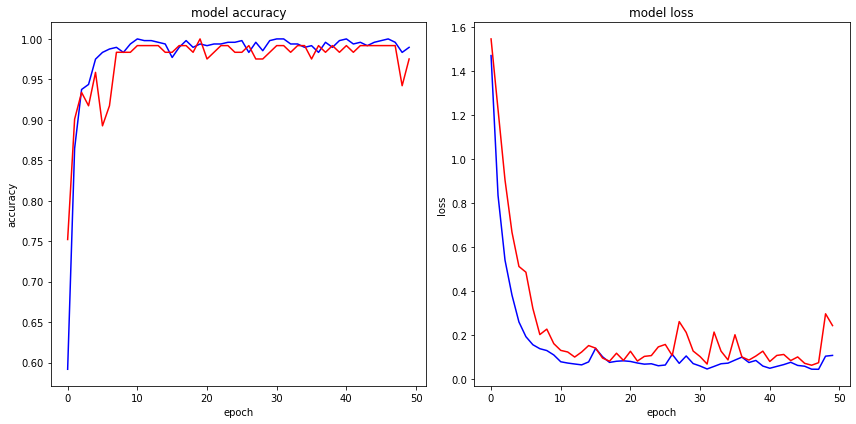

In [12]:
fig = plt.figure(figsize=(12, 6), facecolor='white')
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], 'b')
plt.plot(history.history['val_accuracy'], 'r')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'r')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.tight_layout()

plt.show()

### Train model for each recording with freezing then fine-tuning

In [21]:
BATCH_SIZE = 10
N_EPOCHS_SF = 40
N_EPOCHS_FINETUNE = 60
N_ITERS_ACROSS_SESS = 4
LR_SPAT_FILT = 0.0003
LR_FINE_TUNE = LR_SPAT_FILT / 10

In [14]:
hists = {}
for ep_ix in range(N_ITERS_ACROSS_SESS):
    for p_ix, p_idx in enumerate(np.random.permutation(len(train_participants))):
        
        p_name = train_participants[p_idx]
        rec_info = rec_infos[p_name]
        
        # Load data for this session
        X, Y, ax_info = load_faces_houses(datadir, p_name, feature_set='full')
        
        # Prepare the data for DL
        ds_train, ds_valid, n_train = get_ds_train_valid(X, Y,
                                                         rec_info['trn'],
                                                         rec_info['tst'],
                                                         batch_size=BATCH_SIZE,
                                                         max_offset=MAX_OFFSET)
        
        # Build the model for this session by combining shared layers
        # and individual layer. Each sub-model should keep its weights
        # from previous training.
        _model = tf.keras.Sequential([
            tf.keras.models.load_model(datadir / 'models' / 'shared_head.h5'),
            *ss_layers[p_name],
            tf.keras.models.load_model(datadir / 'models' / 'shared_tail.h5')
        ], name=p_name + '_full')
        
        # Freeze layers and compile with correct optimizer lr.
        _model.layers[0].trainable = False
        _model.layers[-1].trainable = False
        optimizer = tf.keras.optimizers.RMSprop(lr=LR_SPAT_FILT)
        _model.compile(loss='sparse_categorical_crossentropy',
                       optimizer=optimizer, metrics=['accuracy'])
        
        if ep_ix == 0 and p_ix == 0:
            _model.summary()
            
        # Train model
        print("Training model {} ({} of {})".format(_model.name, ep_ix + 1,
                                                    N_ITERS_ACROSS_SESS))
        hist_1 = _model.fit(x=ds_train,
                            epochs=N_EPOCHS_SF,
                            validation_data=ds_valid,
                            verbose=0)
        print("Ending acc and val acc: {:.3f}, {:.3f}".format(
            hist_1.history['accuracy'][-1], hist_1.history['val_accuracy'][-1]))
        
        # Fine-tune model
        # Unfreeze layers and compile.
        _model.layers[0].trainable = True
        _model.layers[-1].trainable = True
        optimizer = tf.keras.optimizers.RMSprop(lr=LR_FINE_TUNE)
        _model.compile(loss='sparse_categorical_crossentropy',
                       optimizer=optimizer, metrics=['accuracy'])
        
        if ep_ix == 0 and p_ix == 0:
            _model.summary()
        
        print("Fine-tuning model {} ({} of {})".format(_model.name, ep_ix + 1,
                                                       N_ITERS_ACROSS_SESS))
        hist_2 = _model.fit(x=ds_train,
                            epochs=N_EPOCHS_FINETUNE,
                            validation_data=ds_valid,
                            verbose=0)
        print("Ending acc and val acc: {:.3f}, {:.3f}".format(
            hist_2.history['accuracy'][-1], hist_2.history['val_accuracy'][-1]))
        
        if p_name not in hists:
            hists[p_name] = []
        hists[p_name].append(hist_1.history)
        hists[p_name].append(hist_2.history)
        
        _model.layers[0].save(datadir / 'models' / 'shared_head.h5')
        _model.layers[-1].save(datadir / 'models' / 'shared_tail.h5')

W0906 10:02:42.849062 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:02:42.925053 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Model: "jt_full"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
shared_head (Model)          (None, 701, None, 12)     3908      
_________________________________________________________________
depthwise_conv2d_8 (Depthwis (None, 701, None, 24)     2448      
_________________________________________________________________
activation_10 (Activation)   (None, 701, None, 24)     0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 701, None, 24)     2804      
_________________________________________________________________
shared_tail (Model)          (None, 3)                 2495      
Total params: 11,655
Trainable params: 3,850
Non-trainable params: 7,805
_________________________________________________________________
Training model jt_full (1 of 5)
Ending acc and val acc: 0.903, 0.833
Model: "jt_full"
________________________________

W0906 10:03:53.074028 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:03:53.149371 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model wc_full (1 of 5)
Ending acc and val acc: 0.947, 0.950
Fine-tuning model wc_full (1 of 5)
Ending acc and val acc: 0.981, 0.966


W0906 10:04:40.237015 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:04:40.309350 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model aa_full (1 of 5)
Ending acc and val acc: 0.926, 0.827
Fine-tuning model aa_full (1 of 5)
Ending acc and val acc: 0.958, 0.845


W0906 10:05:28.017940 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:05:28.094570 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model ha_full (1 of 5)
Ending acc and val acc: 0.848, 0.778
Fine-tuning model ha_full (1 of 5)
Ending acc and val acc: 0.928, 0.812


W0906 10:06:16.587562 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:06:16.662690 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model zt_full (1 of 5)
Ending acc and val acc: 0.998, 0.992
Fine-tuning model zt_full (1 of 5)
Ending acc and val acc: 1.000, 0.992


W0906 10:07:18.552325 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:07:18.627086 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model jm_full (1 of 5)
Ending acc and val acc: 0.898, 0.769
Fine-tuning model jm_full (1 of 5)
Ending acc and val acc: 0.946, 0.778


W0906 10:08:15.739996 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:08:15.815416 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model de_full (1 of 5)
Ending acc and val acc: 0.960, 0.926
Fine-tuning model de_full (1 of 5)
Ending acc and val acc: 0.973, 0.917


W0906 10:09:02.305839 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:09:02.379701 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model ap_full (1 of 5)
Ending acc and val acc: 0.946, 0.833
Fine-tuning model ap_full (1 of 5)
Ending acc and val acc: 0.954, 0.825


W0906 10:09:52.896881 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:09:52.972573 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model rn_full (1 of 5)
Ending acc and val acc: 0.932, 0.874
Fine-tuning model rn_full (1 of 5)
Ending acc and val acc: 0.983, 0.874


W0906 10:10:42.920156 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:10:42.994066 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model ja_full (1 of 5)
Ending acc and val acc: 0.985, 0.890
Fine-tuning model ja_full (1 of 5)


W0906 10:11:42.863495 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Ending acc and val acc: 0.996, 0.915


W0906 10:11:42.941231 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model rr_full (1 of 5)
Ending acc and val acc: 0.950, 0.757
Fine-tuning model rr_full (1 of 5)
Ending acc and val acc: 0.971, 0.838


W0906 10:12:00.125519 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:12:00.201085 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model mv_full (1 of 5)
Ending acc and val acc: 0.935, 0.826
Fine-tuning model mv_full (1 of 5)
Ending acc and val acc: 0.962, 0.843


W0906 10:13:01.753711 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:13:01.828470 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model fp_full (1 of 5)
Ending acc and val acc: 0.981, 0.884
Fine-tuning model fp_full (1 of 5)
Ending acc and val acc: 0.996, 0.917


W0906 10:13:57.903227 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:13:57.981491 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model fp_full (2 of 5)
Ending acc and val acc: 0.988, 0.917
Fine-tuning model fp_full (2 of 5)
Ending acc and val acc: 0.988, 0.926


W0906 10:14:53.811105 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:14:54.075331 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model zt_full (2 of 5)
Ending acc and val acc: 1.000, 0.992
Fine-tuning model zt_full (2 of 5)
Ending acc and val acc: 1.000, 0.983


W0906 10:15:56.191438 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:15:56.270597 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model wc_full (2 of 5)
Ending acc and val acc: 0.989, 0.966
Fine-tuning model wc_full (2 of 5)
Ending acc and val acc: 0.994, 0.966


W0906 10:16:44.190308 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:16:44.275633 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model de_full (2 of 5)
Ending acc and val acc: 0.988, 0.942
Fine-tuning model de_full (2 of 5)
Ending acc and val acc: 0.985, 0.926


W0906 10:17:29.236713 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:17:29.309957 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model mv_full (2 of 5)
Ending acc and val acc: 0.983, 0.860
Fine-tuning model mv_full (2 of 5)
Ending acc and val acc: 0.990, 0.868


W0906 10:18:31.955783 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:18:32.037446 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model jt_full (2 of 5)
Ending acc and val acc: 0.979, 0.774
Fine-tuning model jt_full (2 of 5)
Ending acc and val acc: 0.997, 0.893


W0906 10:19:43.901724 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:19:43.980402 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model rn_full (2 of 5)
Ending acc and val acc: 0.981, 0.882
Fine-tuning model rn_full (2 of 5)
Ending acc and val acc: 0.974, 0.891


W0906 10:20:32.414565 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:20:32.490831 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model aa_full (2 of 5)
Ending acc and val acc: 0.977, 0.873
Fine-tuning model aa_full (2 of 5)
Ending acc and val acc: 0.988, 0.900


W0906 10:21:19.911822 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:21:19.986699 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model ap_full (2 of 5)
Ending acc and val acc: 0.975, 0.825
Fine-tuning model ap_full (2 of 5)
Ending acc and val acc: 0.981, 0.850


W0906 10:22:10.542966 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:22:10.618222 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model jm_full (2 of 5)
Ending acc and val acc: 0.972, 0.846
Fine-tuning model jm_full (2 of 5)
Ending acc and val acc: 0.987, 0.829


W0906 10:23:07.725616 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:23:07.800988 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model ha_full (2 of 5)
Ending acc and val acc: 0.983, 0.880
Fine-tuning model ha_full (2 of 5)


W0906 10:23:54.586251 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Ending acc and val acc: 0.989, 0.880


W0906 10:23:54.668343 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model rr_full (2 of 5)
Ending acc and val acc: 0.986, 0.811
Fine-tuning model rr_full (2 of 5)
Ending acc and val acc: 1.000, 0.811


W0906 10:24:11.934256 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:24:12.011883 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model ja_full (2 of 5)
Ending acc and val acc: 0.996, 0.958
Fine-tuning model ja_full (2 of 5)
Ending acc and val acc: 0.996, 0.949


W0906 10:25:12.502624 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:25:12.581045 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model rr_full (3 of 5)
Ending acc and val acc: 1.000, 0.865
Fine-tuning model rr_full (3 of 5)
Ending acc and val acc: 1.000, 0.838


W0906 10:25:30.089540 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:25:30.181197 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model zt_full (3 of 5)
Ending acc and val acc: 0.992, 0.983
Fine-tuning model zt_full (3 of 5)
Ending acc and val acc: 0.998, 0.992


W0906 10:26:32.170779 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:26:32.248395 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model ha_full (3 of 5)
Ending acc and val acc: 0.989, 0.872
Fine-tuning model ha_full (3 of 5)
Ending acc and val acc: 0.993, 0.897


W0906 10:27:19.777313 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:27:19.853516 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model de_full (3 of 5)
Ending acc and val acc: 0.996, 0.950
Fine-tuning model de_full (3 of 5)
Ending acc and val acc: 0.996, 0.967


W0906 10:28:06.603172 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:28:06.679559 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model aa_full (3 of 5)
Ending acc and val acc: 0.981, 0.927
Fine-tuning model aa_full (3 of 5)
Ending acc and val acc: 0.993, 0.927


W0906 10:28:54.745208 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:28:54.822120 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model rn_full (3 of 5)
Ending acc and val acc: 0.979, 0.882
Fine-tuning model rn_full (3 of 5)
Ending acc and val acc: 0.996, 0.882


W0906 10:29:45.160545 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:29:45.237906 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model ap_full (3 of 5)
Ending acc and val acc: 0.996, 0.867
Fine-tuning model ap_full (3 of 5)
Ending acc and val acc: 0.996, 0.883


W0906 10:30:35.410090 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:30:35.486826 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model ja_full (3 of 5)
Ending acc and val acc: 0.998, 0.958
Fine-tuning model ja_full (3 of 5)
Ending acc and val acc: 1.000, 0.975


W0906 10:31:36.145883 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:31:36.223192 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model mv_full (3 of 5)
Ending acc and val acc: 0.992, 0.851
Fine-tuning model mv_full (3 of 5)
Ending acc and val acc: 0.996, 0.893


W0906 10:32:39.193316 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:32:39.269319 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model jt_full (3 of 5)
Ending acc and val acc: 0.973, 0.869
Fine-tuning model jt_full (3 of 5)
Ending acc and val acc: 0.997, 0.905


W0906 10:33:49.425008 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:33:49.502068 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model wc_full (3 of 5)
Ending acc and val acc: 0.996, 0.975
Fine-tuning model wc_full (3 of 5)
Ending acc and val acc: 0.996, 0.983


W0906 10:34:38.355970 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:34:38.434390 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model jm_full (3 of 5)
Ending acc and val acc: 0.972, 0.838
Fine-tuning model jm_full (3 of 5)
Ending acc and val acc: 0.987, 0.838


W0906 10:35:35.341028 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:35:35.418542 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model fp_full (3 of 5)
Ending acc and val acc: 1.000, 0.926
Fine-tuning model fp_full (3 of 5)
Ending acc and val acc: 0.998, 0.917


W0906 10:36:31.623314 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:36:31.700642 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model ap_full (4 of 5)
Ending acc and val acc: 0.996, 0.883
Fine-tuning model ap_full (4 of 5)
Ending acc and val acc: 0.988, 0.867


W0906 10:37:22.436210 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:37:22.514653 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model ja_full (4 of 5)
Ending acc and val acc: 0.991, 0.949
Fine-tuning model ja_full (4 of 5)
Ending acc and val acc: 0.998, 0.966


W0906 10:38:23.155024 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:38:23.234758 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model wc_full (4 of 5)
Ending acc and val acc: 0.996, 0.975
Fine-tuning model wc_full (4 of 5)
Ending acc and val acc: 1.000, 0.975


W0906 10:39:12.708373 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:39:12.787245 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model aa_full (4 of 5)
Ending acc and val acc: 0.995, 0.900
Fine-tuning model aa_full (4 of 5)
Ending acc and val acc: 0.993, 0.918


W0906 10:40:00.488574 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:40:00.568118 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model rn_full (4 of 5)
Ending acc and val acc: 0.983, 0.857
Fine-tuning model rn_full (4 of 5)
Ending acc and val acc: 0.994, 0.866


W0906 10:40:50.257035 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:40:50.336887 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model jt_full (4 of 5)
Ending acc and val acc: 0.967, 0.917
Fine-tuning model jt_full (4 of 5)
Ending acc and val acc: 1.000, 0.917


W0906 10:42:00.730673 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:42:00.809110 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model fp_full (4 of 5)
Ending acc and val acc: 0.996, 0.893
Fine-tuning model fp_full (4 of 5)
Ending acc and val acc: 0.998, 0.917


W0906 10:42:57.086873 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:42:57.165758 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model jm_full (4 of 5)
Ending acc and val acc: 0.991, 0.838
Fine-tuning model jm_full (4 of 5)
Ending acc and val acc: 0.993, 0.889


W0906 10:43:54.807890 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:43:54.892840 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model ha_full (4 of 5)
Ending acc and val acc: 0.991, 0.897
Fine-tuning model ha_full (4 of 5)
Ending acc and val acc: 0.993, 0.932


W0906 10:44:43.060233 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:44:43.148415 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model de_full (4 of 5)
Ending acc and val acc: 0.990, 0.967
Fine-tuning model de_full (4 of 5)
Ending acc and val acc: 1.000, 0.959


W0906 10:45:28.307931 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:45:28.387761 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model mv_full (4 of 5)
Ending acc and val acc: 0.988, 0.860
Fine-tuning model mv_full (4 of 5)


W0906 10:46:31.319409 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Ending acc and val acc: 0.998, 0.868


W0906 10:46:31.403458 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model rr_full (4 of 5)
Ending acc and val acc: 0.993, 0.811
Fine-tuning model rr_full (4 of 5)
Ending acc and val acc: 0.993, 0.838


W0906 10:46:48.729773 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:46:48.809545 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model zt_full (4 of 5)
Ending acc and val acc: 1.000, 0.967
Fine-tuning model zt_full (4 of 5)
Ending acc and val acc: 1.000, 0.983


W0906 10:47:51.297256 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:47:51.376371 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model wc_full (5 of 5)
Ending acc and val acc: 0.998, 0.983
Fine-tuning model wc_full (5 of 5)
Ending acc and val acc: 0.998, 0.983


W0906 10:48:40.314551 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:48:40.393774 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model zt_full (5 of 5)
Ending acc and val acc: 0.998, 0.967
Fine-tuning model zt_full (5 of 5)
Ending acc and val acc: 1.000, 0.983


W0906 10:49:43.721908 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:49:43.800418 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model mv_full (5 of 5)
Ending acc and val acc: 0.994, 0.826
Fine-tuning model mv_full (5 of 5)
Ending acc and val acc: 0.998, 0.851


W0906 10:50:46.923740 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:50:47.013509 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model rn_full (5 of 5)
Ending acc and val acc: 0.979, 0.891
Fine-tuning model rn_full (5 of 5)
Ending acc and val acc: 0.998, 0.857


W0906 10:51:37.653041 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:51:37.742652 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model jm_full (5 of 5)
Ending acc and val acc: 0.983, 0.863
Fine-tuning model jm_full (5 of 5)
Ending acc and val acc: 0.998, 0.838


W0906 10:52:36.078214 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:52:36.157492 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model aa_full (5 of 5)
Ending acc and val acc: 0.991, 0.918
Fine-tuning model aa_full (5 of 5)
Ending acc and val acc: 1.000, 0.909


W0906 10:53:24.880693 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:53:24.962216 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model jt_full (5 of 5)
Ending acc and val acc: 0.988, 0.821
Fine-tuning model jt_full (5 of 5)
Ending acc and val acc: 0.997, 0.905


W0906 10:54:36.478465 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:54:36.568182 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model ap_full (5 of 5)
Ending acc and val acc: 0.988, 0.867
Fine-tuning model ap_full (5 of 5)
Ending acc and val acc: 0.998, 0.883


W0906 10:55:28.603869 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:55:28.685263 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model ja_full (5 of 5)
Ending acc and val acc: 0.987, 0.966
Fine-tuning model ja_full (5 of 5)
Ending acc and val acc: 1.000, 0.975


W0906 10:56:30.292888 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:56:30.374667 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model ha_full (5 of 5)
Ending acc and val acc: 0.993, 0.932
Fine-tuning model ha_full (5 of 5)
Ending acc and val acc: 0.996, 0.940


W0906 10:57:17.194741 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:57:17.280705 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model de_full (5 of 5)
Ending acc and val acc: 0.990, 0.934
Fine-tuning model de_full (5 of 5)
Ending acc and val acc: 0.996, 0.959


W0906 10:58:01.726018 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:58:01.810222 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model rr_full (5 of 5)
Ending acc and val acc: 1.000, 0.838
Fine-tuning model rr_full (5 of 5)
Ending acc and val acc: 1.000, 0.811


W0906 10:58:19.189199 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:58:19.272592 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model fp_full (5 of 5)
Ending acc and val acc: 0.994, 0.917
Fine-tuning model fp_full (5 of 5)
Ending acc and val acc: 0.998, 0.926


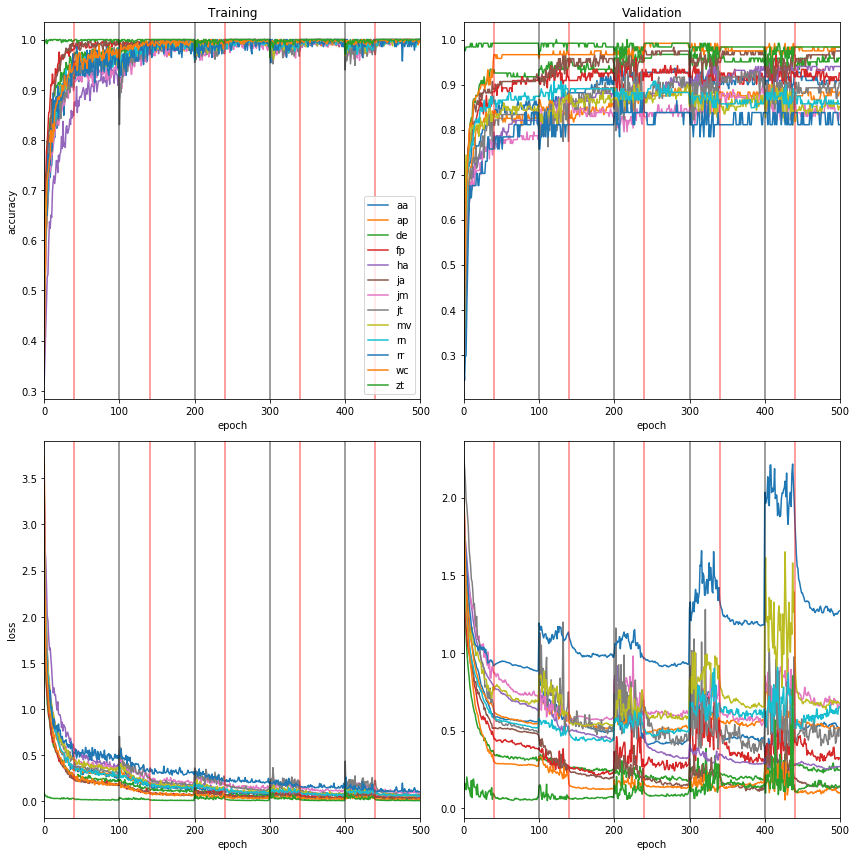

In [26]:
def plt_hist(key):
    # Uses data from outer scope
    sess_breaks = np.arange(N_ITERS_ACROSS_SESS) * (N_EPOCHS_SF + N_EPOCHS_FINETUNE)
    finetune_breaks = sess_breaks + N_EPOCHS_SF
    
    for p_name in train_participants:
        dat = np.hstack([_[key] for _ in hists[p_name]])
        plt.plot(dat, label=p_name)
        plt.xlim([0, N_ITERS_ACROSS_SESS * (N_EPOCHS_SF + N_EPOCHS_FINETUNE)])
    
    for xx in sess_breaks:
        plt.axvline(xx, color='k', alpha=0.5)
    for xx in finetune_breaks:
        plt.axvline(xx, color='r', alpha=0.5)
        
    plt.xlabel('epoch')

fig = plt.figure(figsize=(12, 12), facecolor='white')
plt.subplot(2, 2, 1)
plt_hist('accuracy')
plt.ylabel('accuracy')
plt.title('Training')
plt.legend(loc='lower right')

plt.subplot(2, 2, 2)
plt_hist('val_accuracy')
plt.title('Validation')

plt.subplot(2, 2, 3)
plt_hist('loss')
plt.ylabel('loss')

plt.subplot(2, 2, 4)
plt_hist('val_loss')

plt.tight_layout()
plt.show()

Classification accuracy on the validation set seems to improve as the shared models are updated with each recording.

Validation loss improves for many but not all data sets.

## Transfer the model to unseen data

A single 'test participant' was not included in the above training. Let's see how well we can classify data from this participant using a model that is pre-initialized with weights learned from other subjects and a naive model with random initial weights.

In [16]:
# First clear all models from memory.
reset_keras(shared_head)
reset_keras(shared_tail)

naive_model = tf.keras.Sequential([
    tf.keras.models.load_model(datadir / 'models' / 'shared_head_naive.h5'),
    *ss_layers[test_participant],
    tf.keras.models.load_model(datadir / 'models' / 'shared_tail_naive.h5')
], name=test_participant + '_naive')
naive_model.compile(loss='sparse_categorical_crossentropy',
                   optimizer='Nadam', metrics=['accuracy'])

# Backup the naive weights for the whole model
naive_model.save_weights(str(datadir / 'models' / (test_participant + '_full_naive.h5')))
    
# Get the transfer model.
xfer_model = tf.keras.Sequential([
    tf.keras.models.load_model(datadir / 'models' / 'shared_head.h5'),
    *ss_layers[test_participant],
    tf.keras.models.load_model(datadir / 'models' / 'shared_tail.h5')
], name='xfer_full')
xfer_model.compile(loss='sparse_categorical_crossentropy',
                   optimizer='Nadam', metrics=['accuracy'])

313070


W0906 10:59:17.924557 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:59:17.997822 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


192


W0906 10:59:18.205652 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 10:59:18.280094 140066644506432 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


In [17]:
N_EPOCHS = 200
N_EPOCHS_SF = 20
shared_layers = [0, 2]

rec_info = rec_infos[test_participant]

# Load data for this session
X, Y, ax_info = load_faces_houses(datadir, test_participant, feature_set='full')

# Prepare the data for DL
ds_train, ds_valid, n_train = get_ds_train_valid(X, Y,
                                                 rec_info['trn'],
                                                 rec_info['tst'],
                                                 batch_size=BATCH_SIZE,
                                                 max_offset=MAX_OFFSET)

# Train model
print("Training xfer model {} spatial filter".format(xfer_model.name))
xfer_model.layers[0].trainable = False
xfer_model.layers[-1].trainable = False
xfer_model.compile(loss='sparse_categorical_crossentropy',
                   optimizer='Nadam', metrics=['accuracy'])
hist_xfer_sf = xfer_model.fit(x=ds_train,
                              epochs=N_EPOCHS_SF,
                              validation_data=ds_valid,
                              verbose=1)

print("Training xfer model {} entirity".format(xfer_model.name))
xfer_model.layers[0].trainable = True
xfer_model.layers[-1].trainable = True
xfer_model.compile(loss='sparse_categorical_crossentropy',
                   optimizer='Nadam', metrics=['accuracy'])
hist_xfer_all = xfer_model.fit(x=ds_train,
                               epochs=N_EPOCHS - N_EPOCHS_SF,
                               validation_data=ds_valid,
                               verbose=1)
print("Ending acc and val acc: {:.3f}, {:.3f}".format(
    hist_xfer_all.history['accuracy'][-1], hist_xfer_all.history['val_accuracy'][-1]))

# Train naive model
print("Training naive model {}".format(naive_model.name))
# Restore naive weights.
naive_model.load_weights(str(datadir / 'models' / (test_participant + '_full_naive.h5')))
naive_model.compile(loss='sparse_categorical_crossentropy',
                    optimizer='Nadam', metrics=['accuracy'])
hist_naive = naive_model.fit(x=ds_train,
                             epochs=N_EPOCHS,
                             validation_data=ds_valid,
                             verbose=1)
print("Ending acc and val acc: {:.3f}, {:.3f}".format(
    hist_naive.history['accuracy'][-1], hist_naive.history['val_accuracy'][-1]))

Training xfer model xfer_full spatial filter
Epoch 1/20
45/45 [==============================] - 1s 31ms/step - loss: 3.1155 - accuracy: 0.5244 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
45/45 [==============================] - 0s 10ms/step - loss: 1.3322 - accuracy: 0.7489 - val_loss: 1.5292 - val_accuracy: 0.5044
Epoch 3/20
45/45 [==============================] - 0s 10ms/step - loss: 1.0063 - accuracy: 0.8244 - val_loss: 1.2635 - val_accuracy: 0.6814
Epoch 4/20
45/45 [==============================] - 0s 10ms/step - loss: 0.8808 - accuracy: 0.8356 - val_loss: 1.1627 - val_accuracy: 0.6814
Epoch 5/20
45/45 [==============================] - 0s 10ms/step - loss: 0.8016 - accuracy: 0.8711 - val_loss: 1.1340 - val_accuracy: 0.6903
Epoch 6/20
45/45 [==============================] - 0s 10ms/step - loss: 0.7543 - accuracy: 0.8733 - val_loss: 1.0526 - val_accuracy: 0.6991
Epoch 7/20
45/45 [==============================] - 0s 10ms/step - loss: 0.6752 - accuracy: 0.9000 - 

Epoch 38/180
45/45 [==============================] - 1s 13ms/step - loss: 0.1402 - accuracy: 0.9889 - val_loss: 0.5022 - val_accuracy: 0.8673
Epoch 39/180
45/45 [==============================] - 1s 12ms/step - loss: 0.1643 - accuracy: 0.9844 - val_loss: 0.3255 - val_accuracy: 0.9381
Epoch 40/180
45/45 [==============================] - 1s 14ms/step - loss: 0.1522 - accuracy: 0.9844 - val_loss: 0.3787 - val_accuracy: 0.9204
Epoch 41/180
45/45 [==============================] - 1s 14ms/step - loss: 0.1913 - accuracy: 0.9844 - val_loss: 0.4678 - val_accuracy: 0.8850
Epoch 42/180
45/45 [==============================] - 1s 15ms/step - loss: 0.1602 - accuracy: 0.9889 - val_loss: 0.3747 - val_accuracy: 0.8850
Epoch 43/180
45/45 [==============================] - 1s 14ms/step - loss: 0.1440 - accuracy: 0.9911 - val_loss: 0.3935 - val_accuracy: 0.9115
Epoch 44/180
45/45 [==============================] - 1s 13ms/step - loss: 0.1743 - accuracy: 0.9756 - val_loss: 0.4196 - val_accuracy: 0.9204

45/45 [==============================] - 1s 13ms/step - loss: 0.0775 - accuracy: 1.0000 - val_loss: 0.3617 - val_accuracy: 0.9027
Epoch 153/180
45/45 [==============================] - 1s 13ms/step - loss: 0.0812 - accuracy: 0.9956 - val_loss: 0.2946 - val_accuracy: 0.9204
Epoch 154/180
45/45 [==============================] - 1s 13ms/step - loss: 0.1047 - accuracy: 0.9911 - val_loss: 0.3744 - val_accuracy: 0.9027
Epoch 155/180
45/45 [==============================] - 1s 13ms/step - loss: 0.1020 - accuracy: 0.9956 - val_loss: 0.3651 - val_accuracy: 0.9204
Epoch 156/180
45/45 [==============================] - 1s 12ms/step - loss: 0.0977 - accuracy: 0.9933 - val_loss: 0.4572 - val_accuracy: 0.8673
Epoch 157/180
45/45 [==============================] - 1s 12ms/step - loss: 0.1307 - accuracy: 0.9889 - val_loss: 0.4977 - val_accuracy: 0.8673
Epoch 158/180
45/45 [==============================] - 1s 13ms/step - loss: 0.0991 - accuracy: 0.9956 - val_loss: 0.4043 - val_accuracy: 0.9027
Epoch 

Epoch 29/200
45/45 [==============================] - 1s 13ms/step - loss: 0.1459 - accuracy: 0.9800 - val_loss: 0.4473 - val_accuracy: 0.8938
Epoch 30/200
45/45 [==============================] - 1s 13ms/step - loss: 0.1859 - accuracy: 0.9756 - val_loss: 0.4902 - val_accuracy: 0.8850
Epoch 31/200
45/45 [==============================] - 1s 13ms/step - loss: 0.1502 - accuracy: 0.9867 - val_loss: 0.3625 - val_accuracy: 0.9027
Epoch 32/200
45/45 [==============================] - 1s 13ms/step - loss: 0.1526 - accuracy: 0.9822 - val_loss: 0.5581 - val_accuracy: 0.8761
Epoch 33/200
45/45 [==============================] - 1s 12ms/step - loss: 0.1472 - accuracy: 0.9844 - val_loss: 0.4862 - val_accuracy: 0.9027
Epoch 34/200
45/45 [==============================] - 1s 13ms/step - loss: 0.1515 - accuracy: 0.9756 - val_loss: 0.4835 - val_accuracy: 0.9027
Epoch 35/200
45/45 [==============================] - 1s 14ms/step - loss: 0.1493 - accuracy: 0.9844 - val_loss: 0.5078 - val_accuracy: 0.8938

45/45 [==============================] - 1s 13ms/step - loss: 0.0968 - accuracy: 0.9978 - val_loss: 0.3903 - val_accuracy: 0.9115
Epoch 144/200
45/45 [==============================] - 1s 13ms/step - loss: 0.0877 - accuracy: 0.9911 - val_loss: 0.4486 - val_accuracy: 0.8761
Epoch 145/200
45/45 [==============================] - 1s 13ms/step - loss: 0.0922 - accuracy: 0.9889 - val_loss: 0.4008 - val_accuracy: 0.9204
Epoch 146/200
45/45 [==============================] - 1s 13ms/step - loss: 0.1032 - accuracy: 0.9889 - val_loss: 0.3564 - val_accuracy: 0.9204
Epoch 147/200
45/45 [==============================] - 1s 14ms/step - loss: 0.1050 - accuracy: 0.9844 - val_loss: 0.3970 - val_accuracy: 0.9027
Epoch 148/200
45/45 [==============================] - 1s 14ms/step - loss: 0.0829 - accuracy: 0.9978 - val_loss: 0.4112 - val_accuracy: 0.9115
Epoch 149/200
45/45 [==============================] - 1s 13ms/step - loss: 0.0964 - accuracy: 0.9889 - val_loss: 0.4734 - val_accuracy: 0.9027
Epoch 

Epoch 200/200
45/45 [==============================] - 1s 13ms/step - loss: 0.0753 - accuracy: 0.9978 - val_loss: 0.3410 - val_accuracy: 0.9115
Ending acc and val acc: 0.998, 0.912


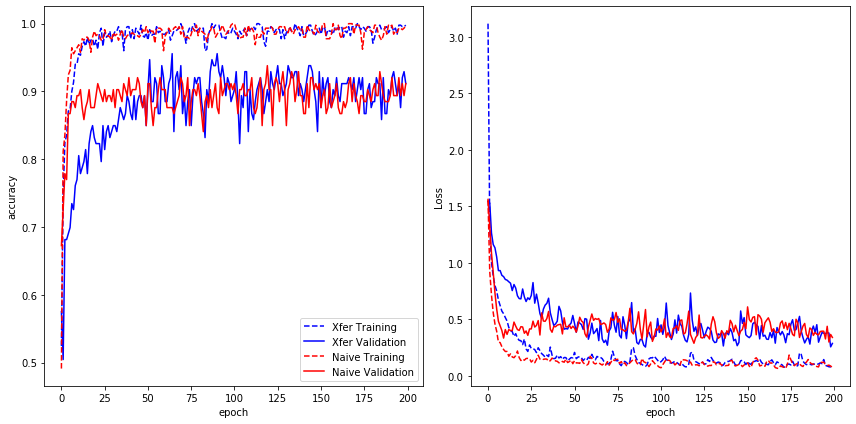

In [18]:
fig = plt.figure(figsize=(12, 6), facecolor='white')
hist_xfer = {}
for k in hist_xfer_sf.history.keys():
    hist_xfer[k] = hist_xfer_sf.history[k] + hist_xfer_all.history[k]
plt.subplot(1, 2, 1)
plt.plot(hist_xfer['accuracy'], 'b--', label='Xfer Training')
plt.plot(hist_xfer['val_accuracy'], 'b', label='Xfer Validation')
plt.plot(hist_naive.history['accuracy'], 'r--', label='Naive Training')
plt.plot(hist_naive.history['val_accuracy'], 'r', label='Naive Validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.subplot(1, 2, 2)
plt.plot(hist_xfer['loss'], 'b--', label='Xfer Training')
plt.plot(hist_xfer['val_loss'], 'b', label='Xfer Validation')
plt.plot(hist_naive.history['loss'], 'r--', label='Naive Training')
plt.plot(hist_naive.history['val_loss'], 'r', label='Naive Validation')
plt.ylabel('Loss')
plt.xlabel('epoch')

plt.tight_layout()
plt.show()

oof. Not what we were hoping for. The model with randomly-initialized weights (naive) trained faster. However, the transfer model (Xfer) had better peak performance.

There are a couple things we could do differently:

1. For each of the training sessions, calculate the covariance matrix for the output of the spatial filter. Then, for the test session, find a mapping from sensor space to a space that has similar covariance. Use this mapping to initialize the spatial filter in the test transfer model.
2. The intended use case of the transfer model on a new dataset is to given decent performance when there is a paucity of training data. We can simulate that by running the above analysis for different levels of training data.